In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow

In [6]:
tensorflow.__version__

'1.15.2'

In [7]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/My Drive/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 10s 1ms/step - loss: 1.1797 - accuracy: 0.7240 - val_loss: 1.0712 - val_accuracy: 0.6997
Epoch 2/50
8000/8000 [==============================] - 8s 1ms/step - loss: 0.8485 - accuracy: 0.7691 - val_loss: 0.8551 - val_accuracy: 0.7624
Epoch 3/50
8000/8000 [==============================] - 9s 1ms/step - loss: 0.6885 - accuracy: 0.8073 - val_loss: 0.7087 - val_accuracy: 0.7950
Epoch 4/50
8000/8000 [==============================] - 8s 1ms/step - loss: 0.5927 - accuracy: 0.8275 - val_loss: 0.6431 - val_accuracy: 0.8120
Epoch 5/50
8000/8000 [============

In [8]:
pwd

'/content'

In [9]:
cd drive

/content/drive


In [10]:
cd My\ Drive

/content/drive/My Drive


# 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


keras/lstm_seq2seq.py at master · keras-team/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

1から55行目 : ライブラリのimport
57から62行目 : ハイパーパラメータの設定

# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [13]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 10.97 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [15]:
cd cocoapi/PythonAPI/

/content/drive/My Drive/cocoapi/PythonAPI


In [16]:
!make
!python setup.py build
!python setup.py install

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../co

In [17]:
cd ../../

/content/drive/My Drive


In [18]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 901, done.
remote: Total 901 (delta 0), reused 0 (delta 0), pack-reused 901
Receiving objects: 100% (901/901), 12.80 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (482/482), done.


In [19]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [32]:
pwd

'/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [28]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
!unzip pretrained_model.zip

!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
!unzip vocap.zip

--2020-04-16 04:10:35--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2020-04-16 04:10:35--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ac1491c9f7e1e8184b35f7499.dl.dropboxusercontent.com/cd/0/inline/A14IwjBD25nlJ_bzyB8bHklZxyv1rHUq0A24bB1E7Hbi1HsftWyfLZ3b6PKrs_YhIUGDOuKvl4zDO7q7dvq4g5P-uYNawXY2bjdimeq4YdGdnKm7BbkKc7R_G_yNjrl4iiM/file# [following]
--2020-04-16 04:10:35--  https://uc2ac1491c9f7e1e8184b35f7499.dl.dropboxusercontent.com/cd/0/inline/A14IwjBD25nlJ_bzyB8bHklZxyv1rHUq0A24bB1E7Hbi1HsftWyfLZ3b6PKrs_YhIUGDOuKvl4zDO7q7dvq4g5P-uY

In [30]:
pwd

'/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning'

sample.py 実行時に利用する学習ずみモデルの重みは[models],[data]のディレクトリに保管

In [35]:
# 実行ファイル
!python sample.py --image='/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/panoramio_(210).jpg'

<start> a train is traveling down a track near a mountain . <end>


In [0]:
from PIL import Image
img = Image.open('/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/panoramio_(210).jpg')

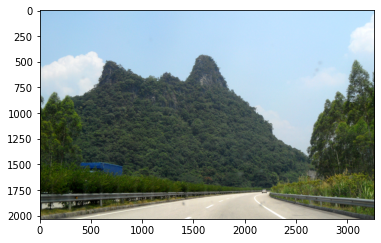

In [38]:
import matplotlib.pyplot as plt
# 推定した画像
plt.imshow(img)
plt.show();

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

### ①モデルの変換について

PyTorchのモデルはNCHWというchannel_first形式でモデルが定義されるが、KerasのモデルでNHWCの並びなので変換必要<br>
１、Pytorchでモデル作成、保存<br>
２、学習済みモデルをONNX形式に変換して保存　(＊ONNX形式とは：https://docs.microsoft.com/ja-jp/windows/ai/windows-ml/get-onnx-model)<br>
３、ONNX形式のモデルをKerasのモデルに変換<br>

### ②モデル

# 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

# 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


《機械翻訳の発展的手法にはどのようなものがある？》


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


《文章から画像生成するには？》


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。